# Microsoft Stock EDA - Variance Prediction

## Import Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zongaobian/microsoft-stock-data-and-key-affiliated-companies")

print("Path to dataset files:", path)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /root/.cache/kagglehub/datasets/zongaobian/microsoft-stock-data-and-key-affiliated-companies/versions/1


## Import Dependencies

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from catboost import CatBoostRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

## Load Datasets

In [3]:
dell_df = pd.read_csv(path + "/DELL_daily_data.csv")
intc_df = pd.read_csv(path + "/INTC_daily_data.csv")
sony_df = pd.read_csv(path + "/SONY_daily_data.csv")
ibm_df = pd.read_csv(path + "/IBM_daily_data.csv")
msft_df = pd.read_csv(path + "/MSFT_daily_data.csv")
vz_df = pd.read_csv(path + "/VZ_daily_data.csv")


## EDA

### Data preparation

#### Convert Dataframes day to DateTime

In [4]:
# Convert date to datetime
dell_df['Date'] = pd.to_datetime(dell_df['Date'])
intc_df['Date'] = pd.to_datetime(intc_df['Date'])
sony_df['Date'] = pd.to_datetime(sony_df['Date'])
ibm_df['Date'] = pd.to_datetime(ibm_df['Date'])
msft_df['Date'] = pd.to_datetime(msft_df['Date'])
vz_df['Date'] = pd.to_datetime(vz_df['Date'])

#### Variance between close prices

In [5]:
# Calculate variance from day to day for each dataset
dell_df['Variance'] = dell_df['Close'].diff().fillna(0) / dell_df['Close'].shift(1).fillna(0)
intc_df['Variance'] = intc_df['Close'].diff().fillna(0) / intc_df['Close'].shift(1).fillna(0)
sony_df['Variance'] = sony_df['Close'].diff().fillna(0) / sony_df['Close'].shift(1).fillna(0)
ibm_df['Variance'] = ibm_df['Close'].diff().fillna(0) / ibm_df['Close'].shift(1).fillna(0)
msft_df['Variance'] = msft_df['Close'].diff().fillna(0) / msft_df['Close'].shift(1).fillna(0)
vz_df['Variance'] = vz_df['Close'].diff().fillna(0) / vz_df['Close'].shift(1).fillna(0)

msft_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Variance
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.059946,1031788800,NaN
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062087,308160000,0.035712
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063158,133171200,0.017250
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061552,67766400,-0.025432
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060482,47894400,-0.017390


#### MA between close prices

In [6]:
# Calculate the moving average for each dataset
dell_df['MA'] = dell_df['Close'].rolling(window=10).mean()
intc_df['MA'] = intc_df['Close'].rolling(window=10).mean()
sony_df['MA'] = sony_df['Close'].rolling(window=10).mean()
ibm_df['MA'] = ibm_df['Close'].rolling(window=10).mean()
msft_df['MA'] = msft_df['Close'].rolling(window=10).mean()
vz_df['MA'] = vz_df['Close'].rolling(window=10).mean()

#### Create Datasets by Year

In [7]:
# Resample data to yearly frequency and calculate mean variance
dell_yearly = dell_df.resample('YE', on='Date').mean()
intc_yearly = intc_df.resample('YE', on='Date').mean()
sony_yearly = sony_df.resample('YE', on='Date').mean()
ibm_yearly = ibm_df.resample('YE', on='Date').mean()
msft_yearly = msft_df.resample('YE', on='Date').mean()
vz_yearly = vz_df.resample('YE', on='Date').mean()

### Plotting

#### Yearly Variance of close prices

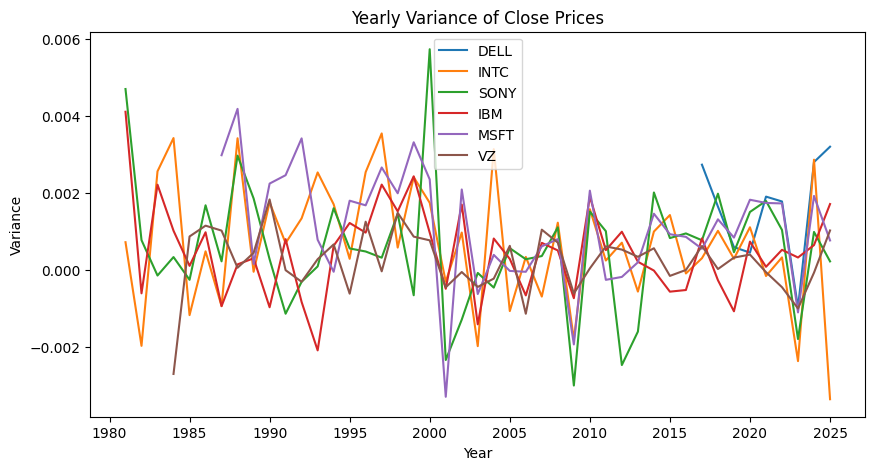

In [8]:
# Plot yearly variance for each dataset
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(dell_yearly.index, dell_yearly['Variance'], label='DELL')
plt.plot(intc_yearly.index, intc_yearly['Variance'], label='INTC')
plt.plot(sony_yearly.index, sony_yearly['Variance'], label='SONY')
plt.plot(ibm_yearly.index, ibm_yearly['Variance'], label='IBM')
plt.plot(msft_yearly.index, msft_yearly['Variance'], label='MSFT')
plt.plot(vz_yearly.index, vz_yearly['Variance'], label='VZ')
ax.set_title('Yearly Variance of Close Prices')
ax.set_xlabel('Year')
ax.set_ylabel('Variance')
ax.legend()
plt.show()

#### Yearly Moving Averages of close prices

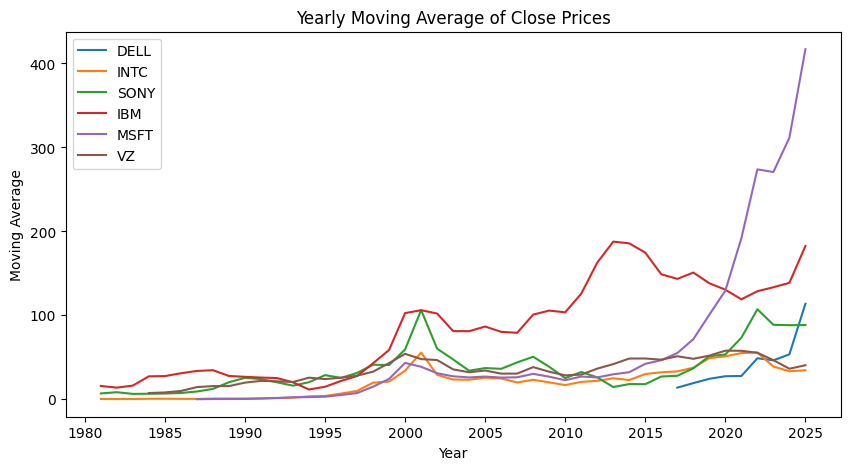

In [9]:
# Plot yearly moving average for each dataset
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(dell_yearly.index, dell_yearly['MA'], label='DELL')
plt.plot(intc_yearly.index, intc_yearly['MA'], label='INTC')
plt.plot(sony_yearly.index, sony_yearly['MA'], label='SONY')
plt.plot(ibm_yearly.index, ibm_yearly['MA'], label='IBM')
plt.plot(msft_yearly.index, msft_yearly['MA'], label='MSFT')
plt.plot(vz_yearly.index, vz_yearly['MA'], label='VZ')
ax.set_title('Yearly Moving Average of Close Prices')
ax.set_xlabel('Year')
ax.set_ylabel('Moving Average')
ax.legend()
plt.show()

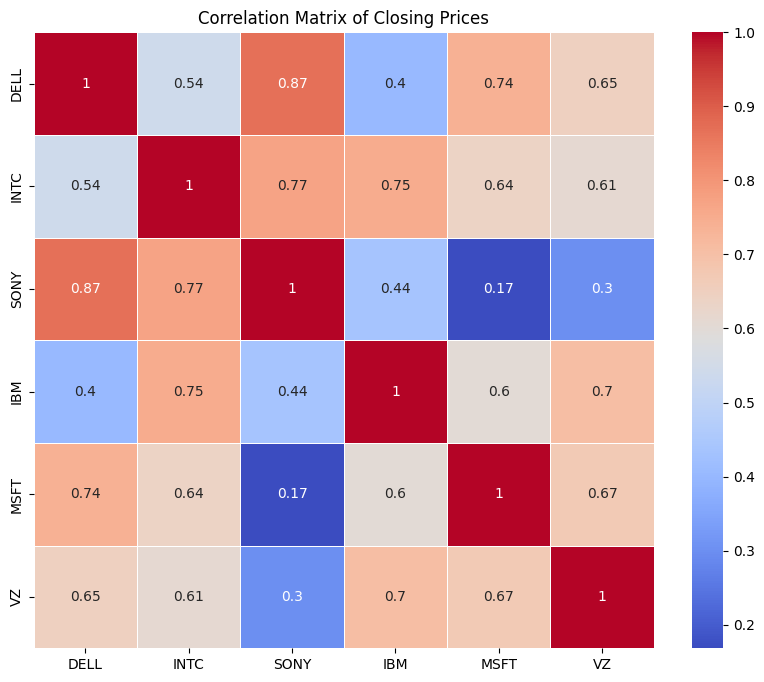

In [10]:
# Create a new DataFrame with the closing prices of each company
closing_prices = pd.DataFrame({
    'DELL': dell_df['Close'],
    'INTC': intc_df['Close'],
    'SONY': sony_df['Close'],
    'IBM': ibm_df['Close'],
    'MSFT': msft_df['Close'],
    'VZ': vz_df['Close']
})


# Calculate the correlation matrix
correlation_matrix = closing_prices.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Closing Prices')
plt.show()

## Predictions

### Data preparation

#### Unify dataframes

In [11]:
unified_df = msft_df.join(dell_df.set_index('Date'), rsuffix='_dell', how='inner', on='Date').join(intc_df.set_index('Date'), rsuffix='_intc', how='inner', on='Date').join(sony_df.set_index('Date'), rsuffix='_sony', how='inner', on='Date').join(ibm_df.set_index('Date'), rsuffix='_ibm', how='inner', on='Date').join(vz_df.set_index('Date'), rsuffix='_vz', how='inner', on='Date')
unified_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Variance,MA,Open_dell,...,Variance_ibm,MA_ibm,Open_vz,High_vz,Low_vz,Close_vz,Adj Close_vz,Volume_vz,Variance_vz,MA_vz
7672,2016-08-17,57.540001,57.680000,57.230000,57.560001,51.918800,18856400,0.002089,57.899000,12.207997,...,-0.001618,154.822180,52.900002,53.169998,52.380001,53.169998,35.394119,12930100,0.007771,53.568
7673,2016-08-18,57.419998,57.700001,57.270000,57.599998,51.954880,14214300,0.000695,57.920000,12.348319,...,0.005734,154.804015,52.950001,53.060001,52.520000,52.869999,35.194412,11204900,-0.005642,53.462
7674,2016-08-19,57.430000,57.730000,57.200001,57.619999,51.972927,17271000,0.000347,57.886000,11.983482,...,-0.008180,154.473230,52.889999,52.910000,52.160000,52.450001,34.914837,11991000,-0.007944,53.343
7675,2016-08-22,57.599998,57.750000,57.259998,57.669998,52.018028,15221900,0.000868,57.846999,12.067676,...,-0.000250,154.278201,52.580002,52.689999,52.169998,52.549999,34.981400,8183900,0.001907,53.239
7676,2016-08-23,57.900002,58.180000,57.849998,57.889999,52.216454,18732400,0.003815,57.815999,12.278158,...,0.001625,154.133841,52.660000,52.820000,52.459999,52.630001,35.034657,7775100,0.001522,53.136


#### Create train Data
We will create the Train data using the Variance of each enterprise multiplying it for the correlation with msft Variance.

In [12]:
# Extract the  Variance columns for each company except Microsoft
data = {
    'Date': unified_df['Date'],
    'DELL_Variance': unified_df['Variance_dell'],
    'INTC_Variance': unified_df['Variance_intc'],
    'SONY_Variance': unified_df['Variance_sony'],
    'IBM_Variance': unified_df['Variance_ibm'],
    'VZ_Variance': unified_df['Variance_vz'],
    'DELL_MA': unified_df['MA_dell'],
    'INTC_MA': unified_df['MA_intc'],
    'SONY_MA': unified_df['MA_sony'],
    'IBM_MA': unified_df['MA_ibm'],
    'VZ_MA': unified_df['MA_vz'],
    'MSFT_MA': unified_df['MA']
}

# Create a DataFrame
train = pd.DataFrame(data)

train.head()

,Date,DELL_Variance,INTC_Variance,SONY_Variance,IBM_Variance,VZ_Variance,DELL_MA,INTC_MA,SONY_MA,IBM_MA,VZ_MA,MSFT_MA
7672,2016-08-17,NaN,-0.005396,-0.012508,-0.001618,0.007771,NaN,34.844,32.708999,154.822180,53.568,57.899000
7673,2016-08-18,-0.005814,-0.001428,0.022552,0.005734,-0.005642,NaN,34.883,32.758999,154.804015,53.462,57.920000
7674,2016-08-19,0.017544,0.007721,-0.011480,-0.008180,-0.007944,NaN,34.909,32.758999,154.473230,53.343,57.886000
7675,2016-08-22,0.003448,0.003405,0.008863,-0.000250,0.001907,NaN,34.941,32.829999,154.278201,53.239,57.846999
7676,2016-08-23,0.030928,0.001131,0.003332,0.001625,0.001522,NaN,34.989,32.856999,154.133841,53.136,57.815999


We will also shift one day train data because in a real scenario we would have the variance of the previous day, not the one we will try to predict.

In [13]:
train.set_index('Date', inplace=True)
train_shifted = train.shift(1)
train_shifted.head()

,DELL_Variance,INTC_Variance,SONY_Variance,IBM_Variance,VZ_Variance,DELL_MA,INTC_MA,SONY_MA,IBM_MA,VZ_MA,MSFT_MA
Date,,,,,,,,,,,
2016-08-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-18,NaN,-0.005396,-0.012508,-0.001618,0.007771,NaN,34.844,32.708999,154.822180,53.568,57.899000
2016-08-19,-0.005814,-0.001428,0.022552,0.005734,-0.005642,NaN,34.883,32.758999,154.804015,53.462,57.920000
2016-08-22,0.017544,0.007721,-0.011480,-0.008180,-0.007944,NaN,34.909,32.758999,154.473230,53.343,57.886000
2016-08-23,0.003448,0.003405,0.008863,-0.000250,0.001907,NaN,34.941,32.829999,154.278201,53.239,57.846999


We will set a frequence of day in the train_shifted to make it have all the days. <br>
After this we will set all the missing variance to 0 as they are weekends and holidays that the market is off. <br>
In the case of MA values, we will fill them with the last available value.

In [14]:
# Filling missing dates
train_shifted = train_shifted.asfreq('D')
# Filling missing Variance with 0
train_shifted[['DELL_Variance', 'INTC_Variance', 'SONY_Variance', 'IBM_Variance', 'VZ_Variance']] = train_shifted[['DELL_Variance', 'INTC_Variance', 'SONY_Variance', 'IBM_Variance', 'VZ_Variance']].fillna(0)
# Filling missing moving averages with the last available value
train_shifted = train_shifted.ffill()

#### Create y
Our y will be the MSFT variance, we will also set it as a frequency of days and fill the variance with 0.

In [15]:
y=unified_df[['Date', 'Variance']]
y.set_index('Date', inplace=True)
# Fill missing dates
y = y.asfreq('D')
# Fill missing Variance with 0
y = y.fillna(0)
y.head()

,Variance
Date,
2016-08-17,0.002089
2016-08-18,0.000695
2016-08-19,0.000347
2016-08-20,0.000000
2016-08-21,0.000000


#### Splitting X_train and X_test and y_train and y_test

In [16]:
X_train = train_shifted.loc[train_shifted.index < '2024-08-01']
X_test = train_shifted.loc[train_shifted.index >= '2024-08-01']
y_train = y.loc[y.index < '2024-08-01']
y_test = y.loc[y.index >= '2024-08-01']

#### Setting the X_train, y_train, X_test and y_test index to DateTime

In [17]:
X_train.index = pd.to_datetime(X_train.index)
X_test.index = pd.to_datetime(X_test.index)
y_train.index = pd.to_datetime(y_train.index)
y_test.index = pd.to_datetime(y_test.index)


### Creating Model
Our Model will use a CatBoostRegressor as the regressor and skforecast. We will also tune it to find the best parameters grid_search_forecaster.

In [18]:
# Define the forecaster
forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_state=42, 
                                verbose=False,
                                ),
    lags=60 # Number of lags to include in the model
)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [500, 750, 1000],
    'learning_rate': [0.001 ,0.01, 0.1],
    'random_strength': [1, 2, 3],
}

lags_grid = [30, 45, 60, 90, [1,2,3,4,5,7,9,13,15,20,50], 120]

# Perform grid search to find the best hyperparameters
results_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=y_train['Variance'],
    exog=X_train,
    param_grid=param_grid,
    lags_grid=lags_grid,
    steps=58,
    metric='mean_squared_error',
    initial_train_size=int(len(y_train) * 0.8),
    fixed_train_size=False,
    return_best=True,
    verbose=False
)


Number of models compared: 162.


lags grid: 100%|██████████████████████████████████████████████████████████████████████████| 6/6 [08:50<00:00, 88.38s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60] 
  Parameters: {'learning_rate': 0.001, 'n_estimators': 750, 'random_strength': 1}
  Backtesting metric: 0.0001476199057743008



#### Fitting the model

In [19]:
# Fit the forecaster with the best parameters
forecaster.fit(y=y_train['Variance'], exog=X_train)

### Predictions

In [20]:
# Predict the test data
predictions = forecaster.predict(steps=len(y_test), exog=X_test)

# Display the predictions
print(predictions)

2024-08-01    0.000774
2024-08-02    0.000969
2024-08-03    0.000655
2024-08-04    0.000687
2024-08-05    0.000824
2024-08-06    0.001453
2024-08-07    0.000708
2024-08-08    0.000758
2024-08-09    0.000712
2024-08-10    0.000670
2024-08-11    0.000658
2024-08-12    0.000785
2024-08-13    0.000806
2024-08-14    0.000682
2024-08-15    0.000819
2024-08-16    0.000761
2024-08-17    0.000704
2024-08-18    0.000671
2024-08-19    0.000640
2024-08-20    0.000685
2024-08-21    0.000837
2024-08-22    0.000700
2024-08-23    0.000927
2024-08-24    0.000708
2024-08-25    0.000698
2024-08-26    0.000674
2024-08-27    0.000715
2024-08-28    0.000690
2024-08-29    0.000775
2024-08-30    0.000734
2024-08-31    0.000675
2024-09-01    0.000671
2024-09-02    0.000698
2024-09-03    0.000564
2024-09-04    0.000910
2024-09-05    0.000974
2024-09-06    0.000779
2024-09-07    0.000699
2024-09-08    0.000688
2024-09-09    0.001079
2024-09-10    0.000505
2024-09-11    0.000688
2024-09-12    0.000682
2024-09-13 

### MSE and MAE of predictions

In [21]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 9.77135022589728e-05
Mean Absolute Error: 0.00686074422811237


### Plotting last close value + predictions vs real close prices

In [23]:
# Create a DataFrame with the closing prices and the predictions
close_df = unified_df[['Date', 'Close']]

# Set the date as the index
close_df.set_index('Date', inplace=True)

# Fill missing dates
close_df = close_df.asfreq('D')

# Fill missing closing prices with the last available value
close_df = close_df.bfill()

# Shift the closing prices one day back
close_df = close_df.shift(1)

# Join the predictions to the DataFrame
close_df = close_df.join(predictions, how='inner', on=close_df.index)

# Rename the columns
close_df = close_df.drop(columns='key_0')


In [24]:
# Rename the columns
close_df = close_df.rename(columns={'Close': 'Close_yesterday', 'pred': 'Variance_prediction'})

close_df_2 = unified_df[['Date', 'Close', 'Variance']]

close_df_2.set_index('Date', inplace=True)

close_df_2 = close_df_2.asfreq('D')

close_df_2 = close_df_2.bfill()

close_df = close_df.join(close_df_2, how='inner', on=close_df.index)

close_df = close_df.drop(columns='key_0')

close_df.head()

,Close_yesterday,Variance_prediction,Close,Variance
Date,,,,
2024-08-01,418.350006,0.000774,417.109985,-0.002964
2024-08-02,417.109985,0.000969,408.489990,-0.020666
2024-08-03,408.489990,0.000655,395.149994,-0.032657
2024-08-04,395.149994,0.000687,395.149994,-0.032657
2024-08-05,395.149994,0.000824,395.149994,-0.032657


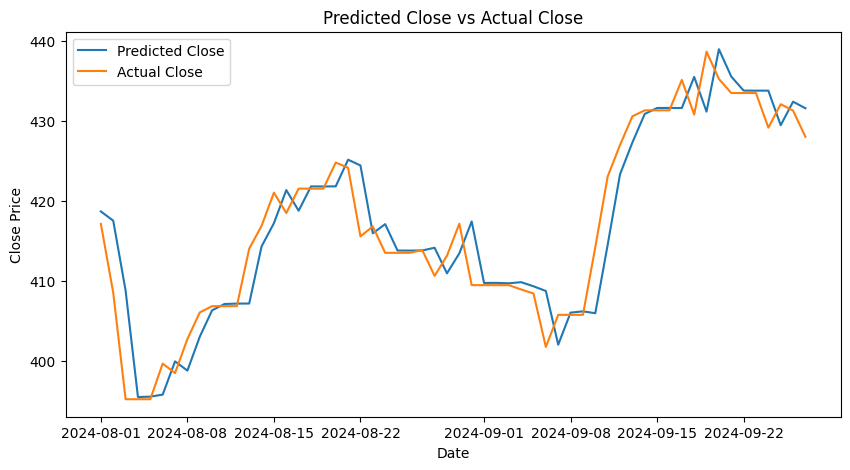

In [25]:
# Calculate the predicted close prices
close_df['Predicted_Close'] = close_df['Close_yesterday'] * (1 + close_df['Variance_prediction'])

# Plot the predicted close prices versus actual close prices
plt.figure(figsize=(10, 5))
plt.plot(close_df.index, close_df['Predicted_Close'], label='Predicted Close')
plt.plot(close_df.index, close_df['Close'], label='Actual Close')
plt.title('Predicted Close vs Actual Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [26]:
close_df.head()

,Close_yesterday,Variance_prediction,Close,Variance,Predicted_Close
Date,,,,,
2024-08-01,418.350006,0.000774,417.109985,-0.002964,418.674016
2024-08-02,417.109985,0.000969,408.489990,-0.020666,417.513992
2024-08-03,408.489990,0.000655,395.149994,-0.032657,408.757654
2024-08-04,395.149994,0.000687,395.149994,-0.032657,395.421391
2024-08-05,395.149994,0.000824,395.149994,-0.032657,395.475640
